In [129]:
import numpy as np
import matplotlib.pyplot as plt

# import lumicks
import lumicks.pylake as lk

# %matplotlib inline
from skimage.transform import rescale
import tifffile
import os
from cv2 import warpAffine, invertAffineTransform
from pathlib import Path
from cv2 import estimateAffine2D, estimateAffinePartial2D
from picasso import io, postprocess
import json
from json import JSONEncoder
import argparse
import itertools
import math
import subprocess

def norm_image(image,inverse=False):
    amin = image.min()
    amax = image.max()
    if inverse:
        return 1- (image-amin)/(amax-amin)    
    else:
        return (image-amin)/(amax-amin)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [ ]:
parser = argparse.ArgumentParser(
    description="""Scripts to align various channels based on reference beads.""",
    epilog="""""",
)
parser.add_argument("wt_file", help="WT tif file")
parser.add_argument("irm_file", help="IRM tif file")
parser.add_argument(
    "-o",
    "--output-directory",
    default="output",
    help="Output directory. Default=output/",
)
parser.add_argument(
    "-m", "--transform-matrix", help="Previously calculated matrix in .json format"
)
parser.add_argument(
    "-f", "--fit_method", default="lq", help="Fit method for picasso.  Default=lq"
)
parser.add_argument(
    "-b", "--box_size", default=21, help="Box sized for picasso. Default=21"
)
parser.add_argument(
    "-g",
    "--min_gradient",
    default=70000,
    help="Minimum gradient for picasso. Default=70000",
)
parser.add_argument(
    "-e",
    "--max_pos_error",
    default=3.5,
    help="Maximum standard dev accepted for x and y position of spots. Default=3.5",
)
parser.add_argument("-p", "--max_photons", help="Maximum number of photons for spots.")


args = parser.parse_args()

irm_path = args.irm_file
wt_path = args.wt_file
output_path = (
    args.output_directory + "/"
)  # The trailing slash is in case it wasn't added by the user

In [158]:
#Just to test without arguments


#irm_path = "data/20231228-A_IRM_0.5_beads.tif" #Reference for calculation
#wt_path =   "data/20231228-A_WT_0.5_beads.tif"

irm_path = "TIRF_IRM/20231212-134034_IRM.tif"  #Test images
wt_path =   "TIRF_IRM/20231212-135041_WT.tif"

output_path="output/"
transform_matrix_exists=True
transform_matrix = "transform_matrix_no_padding.json"
max_photons_exists = False
max_photons=800000
min_gradient=70000
box_size=21
fit_method="lq"
max_pos_error=3.5

In [150]:

# Check if the directory already exists
os.makedirs(output_path, exist_ok=True)

In [151]:
if irm_path.endswith(".tiff"):
    print(irm_path)
    os.rename(irm_path, irm_path[:-1])
    irm_path = irm_path[:-1]
if wt_path.endswith(".tiff"):
    print(wt_path)
    os.rename(wt_path, wt_path[:-1])
    wt_path = wt_path[:-1]

In [152]:
irm = lk.ImageStack(irm_path)  # Loading a stack.
wt = lk.ImageStack(wt_path)  # Loading a stack.
wt.export_tiff(
    output_path + Path(wt_path).stem + "_aligned.tif"
)  # Save aligned wt stack

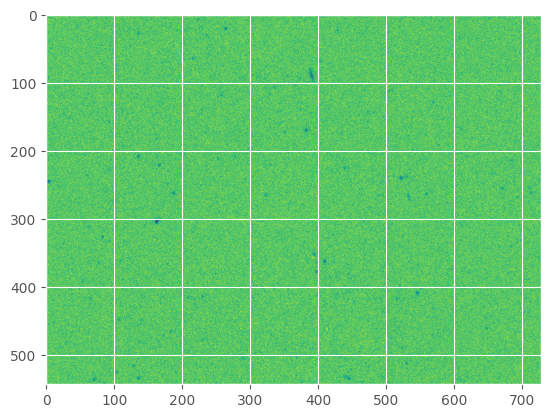

In [153]:

# Get channels
wt_g = wt.get_image(channel="green")
#plt.imshow(wt_g)
# wt_r = wt.get_image(channel='red')  #not really used
# wt_b = wt.get_image(channel='blue') #not really used
irm_g = irm.get_image()
plt.imshow(irm_g)

In [154]:
# Get region of interest data

wt_metadata = wt._tiff_image_metadata()
wt_roi = wt_metadata["Alignment region of interest (x, y, width, height)"]
print(wt_roi)

irm_metadata = irm._tiff_image_metadata()
irm_roi = irm_metadata[
    "Region of interest (x, y, width, height)"
]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
print(irm_roi)

[0, 0, 2048, 682]
[0, 0, 728, 544]


In [155]:
# Pad both images to region of interest
padded_wt_filename = Path(wt_path).stem + "_padded.tif"
#wt_g_padded = np.pad(wt_g, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])
wt_g_padded = wt_g
tifffile.imwrite(output_path + padded_wt_filename, wt_g_padded)
#plt.imshow(wt_g_padded)

padded_irm_filename = Path(irm_path).stem + "_padded.tif"
#irm_g_padded = np.pad(irm_g, [(int(irm_roi[0]), 0), (int(irm_roi[1]), 0)])
irm_g_padded = irm_g
#irm_g_padded = np.pad(irm_g, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])
tifffile.imwrite(output_path + padded_irm_filename, irm_g_padded)
#plt.imshow(irm_g_padded)


In [159]:


transform_mat = []  # set to empty to check afterwards if I have a matrix

if transform_matrix_exists:  # If I have provided a matrix, use that
    with open(transform_matrix, "r") as read_file:
        decodedArray = json.load(read_file)
        transform_mat = np.asarray(decodedArray["transform matrix"])
        rmsd = decodedArray["rmsd"]
else:  # if matrix wasnt provided, calculate it
    run_string = (
        "python -m picasso localize "
        + output_path
        + padded_wt_filename
        + " --fit-method "
        + fit_method
        + " -b "
        + str(box_size)
        + " --gradient "
        + str(min_gradient)
    )
    subprocess.run(run_string)

    run_string = (
        "python -m picasso localize "
        + output_path
        + padded_irm_filename
        + " --fit-method "
        + fit_method
        + " -b "
        + str(box_size)
        + " --gradient "
        + str(min_gradient)
    )
    subprocess.run(run_string)
    #!python -m picasso localize {output_path}wt_padded.tif --fit-method $args.fit_method -b  $args.box_size --gradient $args.min_gradient
    #!python -m picasso localize {output_path}irm_padded.tif --fit-method $args.fit_method -b $args.box_size --gradient $args.min_gradient
    
    

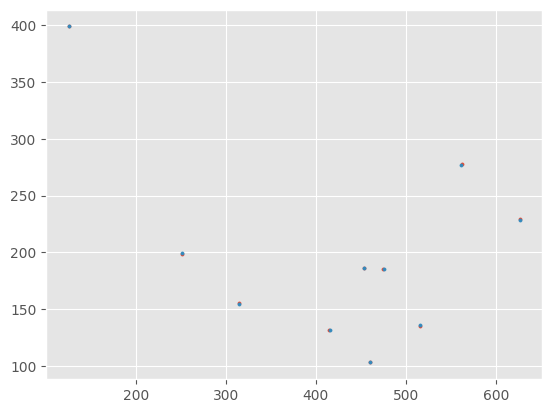

In [146]:
#Only run if calculating matrix

irm_locs_path = output_path + Path(padded_irm_filename).stem + "_locs.hdf5"
irm_locs, irm_info = io.load_locs(irm_locs_path)
wt_locs_path = output_path + Path(padded_wt_filename).stem + "_locs.hdf5"
wt_locs, wt_info = io.load_locs(wt_locs_path)
wt_locs = wt_locs[wt_locs["sx"] < max_pos_error]
wt_locs = wt_locs[wt_locs["sy"] < max_pos_error]
irm_locs = irm_locs[irm_locs["sx"] < max_pos_error]
irm_locs = irm_locs[irm_locs["sy"] < max_pos_error]
if max_photons_exists:
    wt_locs = wt_locs[wt_locs["photons"] < max_photons]
    irm_locs = irm_locs[irm_locs["photons"] < max_photons]

wt_locs_xy = wt_locs[["x", "y"]].copy()
irm_locs_xy = irm_locs[["x", "y"]].copy()

wt_locs_xy = np.vstack([wt_locs_xy[item] for item in ["x", "y"]]).T.astype(
    np.int64
)  # Parse to numpy array:
irm_locs_xy = np.vstack([irm_locs_xy[item] for item in ["x", "y"]]).T.astype(
    np.int64
)

if len(wt_locs_xy) != len(
    irm_locs_xy
):  # If number of points is different after filtering give an error an exit
    print(
        "Different number of spots after filtering (wt: "
        + str(len(wt_locs_xy))
        + " vs irm: "
        + str(len(irm_locs_xy))
        + "). Calculation can't continue"
    )
    print("Check your filtering settings")
else:  # If number of points is the same, calculate affine transform
    affine_transform = estimateAffinePartial2D(irm_locs_xy, wt_locs_xy)
    transform_mat = affine_transform[0]

    # Manually affine transform the points to output alignment plot

    transform_mat_for_points = np.vstack(
        [transform_mat, (0, 0, 1)]
    )  # have to add this row for affine transform

    warped_irm_locs = []

    for point in irm_locs_xy:
        new_point = (
            point[0],
            point[1],
            1,
        )  # need to add a 1 at the end of the point for affine transform
        # print(new_point)
        transformed_point = np.matmul(
            transform_mat_for_points, new_point
        )  # do the transformation
        new_point = (
            transformed_point[0],
            transformed_point[1],
        )  # transformed point
        warped_irm_locs.append(new_point)

    warped_irm_locs = np.array(warped_irm_locs)

    wt_locs_xy_sorted = wt_locs_xy[
        np.lexsort((wt_locs_xy[:, 1], wt_locs_xy[:, 0]))
    ]  # Sort the points in case they are in different orders
    warped_irm_locs_sorted = warped_irm_locs[
        np.lexsort((warped_irm_locs[:, 1], warped_irm_locs[:, 0]))
    ]
    rmsd = np.sqrt(
        ((((wt_locs_xy_sorted - warped_irm_locs_sorted) ** 2)) * 3).mean()
    )  # calculate RMSD

    numpyData = {
        "transform matrix": transform_mat,
        "rmsd": rmsd,
    }  # Write transform matrix and rmsd to file
    with open(output_path + "transform_matrix.json", "w") as write_file:
        json.dump(numpyData, write_file, cls=NumpyArrayEncoder)

    # Remove files created during localization
    os.remove(wt_locs_path)
    os.remove(irm_locs_path)
    os.remove(output_path + Path(wt_locs_path).stem + ".yaml")
    os.remove(output_path + Path(irm_locs_path).stem + ".yaml")
    # Plot aligned points
    plt.scatter(*zip(*wt_locs_xy), s=5)
    plt.scatter(*zip(*warped_irm_locs), s=5)
    plt.savefig(output_path + "aligned_points.png")

19925 21466 38 230


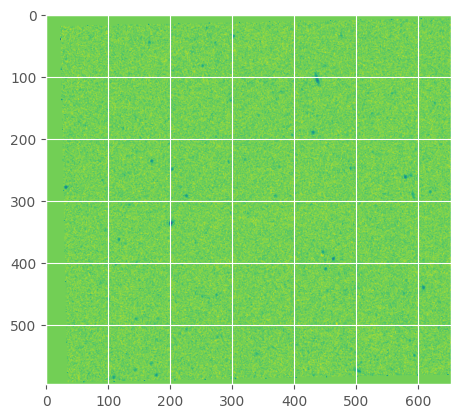

In [176]:
if len(transform_mat != 0):  # If I have a matrix either from file or calculated
    irm_g_padded_warped = warpAffine(
        irm_g_padded, transform_mat, (wt_g_padded.shape[1], wt_g_padded.shape[0])
    )

   
    #This hack is done to reduce the total contrast in the resulting image
    #Otherwise, the 0s make it hard to see
    irm_g_padded_warped[irm_g_padded_warped<=np.amin(irm_g_padded)] = np.mean(irm_g_padded) 
    
    irm_g_padded_warped=norm_image(irm_g_padded_warped,False)        
    wt_g_padded=norm_image(wt_g_padded)

    irm_g_padded_warped_cropped = irm_g_padded_warped[
        0:wt_g.shape[0], 0:wt_g.shape[1]
    ]  # crop to size of wt

    tifffile.imwrite(
        output_path + Path(irm_path).stem + "_aligned.tif",
        irm_g_padded_warped_cropped,
        metadata=irm_metadata,
    )  # save irm image without the padding

    plt.imshow(irm_g_padded_warped_cropped,alpha=1)
    #plt.imshow(wt_g_padded,alpha=0.5)
    
    stacked_image = np.stack(
        [wt_g_padded, irm_g_padded_warped_cropped], axis=0
    )  # Save stacked g and irm image
    tifffile.imwrite(
        output_path + Path(wt_path).stem + "_multichannel_aligned.tif",
        stacked_image,
    )
    #plt.imshow(wt_g)
    # delete padded files
    #os.remove(output_path + padded_irm_filename)
    #os.remove(output_path + padded_wt_filename)